In [1]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "4"

import os
os.chdir("/workspace/Brain2CLIP_Diffusion_v3")
!pip install -r requirements.txt
!pip install accelerate
!pip install --upgrade diffusers

!pip install umap
!pip install fastparquet
!pip install spkit

!pip install --upgrade torchtext
!pip install pytorch-lightning==1.8.3.post0
!pip3 install torch torchvision torchaudio

!pip3 install torch torchvision torchaudio

!pip install mxnet-cu112
!pip install numpy==1.23

In [3]:
import os
import sys
import torch
from typing import Tuple, Union
from mxnet import nd, symbol
from mxnet.gluon.nn import HybridBlock
from mxnet.gluon.parameter import Parameter
from mxnet.initializer import Zero
from mxnet.gluon.nn import Conv2D, HybridSequential, LeakyReLU, Dense
from mxnet import nd, gluon, autograd
import mxnet as mx
from mxnet.io import NDArrayIter
import typing

In [39]:
from transformers import CLIPFeatureExtractor, CLIPModel
from sklearn.linear_model import LinearRegression, SGDClassifier, SGDRegressor

In [5]:
from sklearn.linear_model import Ridge
import pickle
import pandas as pd
from mxnet import nd
from mxnet.io import NDArrayIter
from mxnet.symbol import Symbol
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

sys.path.append("/workspace/Brain2CLIP_Diffusion_v3/lambda_diffusers")

In [6]:
torch.cuda.device_count()

1

In [7]:
 print(torch.version.cuda)

11.7


In [8]:
import os
os.chdir("/workspace/Brain2CLIP_Diffusion_v3/lambda_diffusers/pipelines")


In [9]:
from pipelines.pipeline_stable_diffusion_im_embed import CLIPImageEncoder, StableDiffusionFromLatents
from PIL import Image

In [10]:
def load_dataset(t, x, batch_size):
    return NDArrayIter({ "x": nd.stack(*x, axis=0) }, { "t": nd.stack(*t, axis=0) }, batch_size, True)

In [11]:
subject = 1
batch_size = 30

with open("/workspace/hyper/data_%i.dat" % subject, 'rb') as f:
          X_tr, T_tr, X_te, T_te = pickle.load(f)
          train = load_dataset(nd.array(T_tr), nd.array(X_tr), batch_size)        
          test =  load_dataset(nd.array(T_te), nd.array(X_te), batch_size=36)  

In [12]:
class Linear(HybridSequential):
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
        with self.name_scope():
            self.add(Dense(n_out, in_units=n_in))


class Pixelnorm(HybridBlock):
    def __init__(self, epsilon: float = 1e-8) -> None:
        super(Pixelnorm, self).__init__()
        self.epsilon = epsilon

    def hybrid_forward(self, F, x) -> nd:
        return x * F.rsqrt(F.mean(F.square(x), 1, True) + self.epsilon)


class Bias(HybridBlock):
    def __init__(self, shape: Tuple) -> None:
        super(Bias, self).__init__()
        self.shape = shape
        with self.name_scope():
            self.b = self.params.get("b", init=Zero(), shape=shape)

    def hybrid_forward(self, F, x, b) -> nd:
        return F.broadcast_add(x, b[None, :, None, None])


class Block(HybridSequential):
    def __init__(self, channels: int, in_channels: int) -> None:
        super(Block, self).__init__()
        self.channels = channels
        self.in_channels = in_channels
        with self.name_scope():
            self.add(Conv2D(channels, 3, padding=1, in_channels=in_channels))
            self.add(LeakyReLU(0.2))
            self.add(Pixelnorm())
            self.add(Conv2D(channels, 3, padding=1, in_channels=channels))
            self.add(LeakyReLU(0.2))
            self.add(Pixelnorm())

    def hybrid_forward(self, F, x) -> nd:
        x = F.repeat(x, 2, 2)
        x = F.repeat(x, 2, 3)
        for i in range(len(self)):
            x = self[i](x)
        return x


In [13]:

class Generator(HybridSequential):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        with self.name_scope():
            self.add(Pixelnorm())
            self.add(Dense(8192, use_bias=False, in_units=512))
            self.add(Bias((512,)))
            self.add(LeakyReLU(0.2))
            self.add(Pixelnorm())
            self.add(Conv2D(512, 3, padding=1, in_channels=512))
            self.add(LeakyReLU(0.2))
            self.add(Pixelnorm())
            
            self.add(Block(512, 512)) # 8
            self.add(Block(512, 512))
            self.add(Block(512, 512))
            self.add(Block(256, 512))
            self.add(Block(128, 256))
            self.add(Block(64, 128))
            self.add(Block(32, 64))
            self.add(Block(16, 32)) # 15
            self.add(Conv2D(3, 1, in_channels=16))

    
    def hybrid_forward(self, F: Union[nd.NDArray, Symbol], x: nd, layer: int) -> nd:
        x = F.Reshape(self[1](self[0](x)), (-1, 512, 4, 4))
        for i in range(2, len(self)):
            x = self[i](x)
            if i == layer + 7:
              return x
        return x

In [14]:
generator = Generator()
generator.load_parameters("/workspace/hyper/generator.params")

In [15]:
face = generator(train.label[0][1][77][None], 9).asnumpy()

In [16]:
train.label[0][1].shape

(1050, 512)

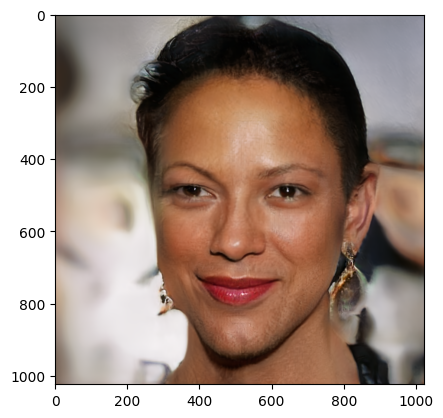

In [17]:
face = np.clip(np.rint(127.5 * face + 127.5), 0.0, 255.0)
face = face.astype("uint8")
face = face.transpose(0, 2, 3, 1)
face = Image.fromarray(face[0], 'RGB')
plt.imshow(face)

In [18]:
face.save("/workspace/outputs/img1.jpg")

In [19]:
def createCLIPLatents(hyper_latents):
    
    sd_pipe = CLIPImageEncoder(CLIPModel, CLIPFeatureExtractor)
    
    latents = []
    
    tform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(
            (224, 224),
            interpolation=transforms.InterpolationMode.BICUBIC,
            antialias=False,
            ),
        transforms.Normalize(
        [0.48145466, 0.4578275, 0.40821073],
        [0.26862954, 0.26130258, 0.27577711]),
        transforms.ToPILImage()
    ])
        
    
    
    for hyper_latent in hyper_latents[0][1]:
        
        face = generator(hyper_latent[None], 9).asnumpy()
        
        face = np.clip(np.rint(127.5 * face + 127.5), 0.0, 255.0)
        face = face.astype("uint8")
        face = face.transpose(0, 2, 3, 1)
        face = Image.fromarray(face[0], 'RGB')
        
        face = tform(face)
        
        clip_latent = sd_pipe(inp)
      
        latents.append([hyper_latent, clip_latent])
        
        
    return latents
        
        
        
    

In [20]:
#latents = createCLIPLatents(train.label)

In [21]:
latents = np.load("/workspace/hyper/latents.npy", allow_pickle=True)

In [22]:
latents[0][0][0:15]


[ 0.30472752  1.569101    0.05305739 -1.0892427  -0.30954027  1.1135652
 -1.0138068  -0.12551616 -1.8231273  -1.3967491  -0.41004625  0.58074546
  1.1873206  -1.236069   -0.18675327]
<NDArray 15 @cpu(0)>

In [23]:
def make_latents_dict(latents):
    latent_dict = {}
    
    for latent_pair in latents:
        
        key = tuple(latent_pair[0].asnumpy())
        latent_dict[key] = latent_pair[1][0][0]
        
    
    return latent_dict

In [24]:
clip_latents_dict = make_latents_dict(latents)

In [25]:
brain_data = train.data[0][1]

In [26]:
gan_latents = []
for gan_latent in train.label[0][1]:
    gan_latents.append(tuple(gan_latent.asnumpy()))
    

In [27]:
len(gan_latents[4])

512

In [28]:
clip_latents = [clip_latents_dict[gan_latent] for gan_latent in gan_latents]

In [29]:
len(clip_latents[4])

768

In [30]:
clip_latents_tensor = torch.stack(clip_latents)

In [40]:
reg = SGDRegressor()

In [42]:
clip_latents[0:15]

[tensor([-4.8941e-01, -2.7113e-01,  2.8360e-01, -1.2546e-01,  4.2139e-01,
         -1.0042e+00, -5.7727e-01,  7.9118e-01, -8.6982e-01, -4.4122e-02,
          5.3093e-02, -5.2878e-01,  9.8257e-01,  3.0849e-01, -6.7113e-01,
          2.2819e-01,  7.8703e-02,  1.9291e-02,  4.3459e-01, -3.6830e-01,
         -1.6760e-01,  4.9777e-01,  2.5504e-01, -2.0036e-01, -1.3084e-01,
         -2.1771e-01, -9.2404e-01, -9.6775e-01,  8.7522e-01, -1.1742e-02,
         -4.7596e-02, -1.5845e-01, -3.7161e-01, -7.4557e-02, -4.8448e-01,
         -1.9163e-01, -3.3867e-01, -6.3375e-01,  1.5081e-01,  2.7282e-01,
         -1.9754e-01,  2.4635e-01,  4.1707e-02, -7.6937e-01, -1.0093e-01,
          5.8705e-01,  1.7796e-01,  8.8414e-01,  3.2966e-01, -5.4760e-01,
          7.6203e-02, -2.0808e-01,  1.6762e-01, -2.1650e-01, -4.6661e-01,
         -2.5529e-01, -5.3476e-01,  1.9472e-01, -3.0204e-01, -4.2876e-02,
         -9.3116e-02, -1.2159e-01, -2.5074e-01,  4.8123e-01,  5.5380e-01,
          2.4658e-01,  2.2510e-01, -4.

In [38]:
for i in range(0,len(clip_latents),30):
 print(i)
 print(i, i+29)

0
0 29
30
30 59
60
60 89
90
90 119
120
120 149
150
150 179
180
180 209
210
210 239
240
240 269
270
270 299
300
300 329
330
330 359
360
360 389
390
390 419
420
420 449
450
450 479
480
480 509
510
510 539
540
540 569
570
570 599
600
600 629
630
630 659
660
660 689
690
690 719
720
720 749
750
750 779
780
780 809
810
810 839
840
840 869
870
870 899
900
900 929
930
930 959
960
960 989
990
990 1019
1020
1020 1049


In [44]:
type(brain_data)

mxnet.ndarray.ndarray.NDArray

In [43]:


for i in range(0,len(clip_latents),30):
    
    reg.partial_fit(brain_data[i:i+29], clip_latents[i:i+29])

ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 32.

In [45]:
reg = LinearRegression().fit(torch.from_numpy(brain_data.asnumpy()), clip_latents_tensor)

In [30]:
#reg = torch.linalg.lstsq(torch.from_numpy(brain_data.asnumpy()).to('cuda'), clip_latents_tensor.to('cuda')).solution

In [53]:
brain = torch.from_numpy(brain_data.asnumpy())


In [56]:
brain[4].shape

torch.Size([4096])

In [46]:
reg

LinearRegression()

In [51]:
brain_data_tensor = torch.from_numpy(brain_data.asnumpy())

In [59]:
reconstruction = reg.predict(brain_data_tensor[10:20])

In [60]:
reconstruction.shape

(10, 768)

## First images from brain data with stable diffusion!

In [61]:
import inspect
import warnings
from typing import List, Optional, Union
from torchvision import transforms

import torch
import PIL

import numpy
from transformers import CLIPFeatureExtractor, CLIPModel

from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.pipeline_utils import DiffusionPipeline
from diffusers.schedulers import DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker

In [62]:
from pipelines.pipeline_stable_diffusion_im_embed import CLIPImageEncoder, StableDiffusionFromLatents, StableDiffusionImageEmbedPipeline
from pipelines.pipeline_stable_diffusion_im_embed import StableDiffusionImageEmbedPipeline as vanilla_diffusion
from PIL import Image

In [63]:

device = "cuda:0"
stable_diffusion = StableDiffusionFromLatents.from_pretrained(
  "lambdalabs/sd-image-variations-diffusers",
  revision="v2.0",
  )




















































































































































































































































































































































































































































































Fetching 11 files:  27%|██▋       | 3/11 [00:24<01:12,  9.06s/it]

Fetching 11 files:  55%|█████▍    | 6/11 [00:24<00:17,  3.56s/it]



















































































































































































Fetching 11 files: 100%|██████████| 11/11 [00:43<00:00,  3.99s/it]
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is st

device = "cuda:0"
stable_diffusion2 = vanilla_diffusion.from_pretrained(
  "lambdalabs/sd-image-variations-diffusers",
  revision="v2.0",
  )


In [64]:
stable_diffusion = stable_diffusion.to('cuda')
#stable_diffusion2 = stable_diffusion2.to('cuda')

In [42]:
'''
tform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(
        (224, 224),
        interpolation=transforms.InterpolationMode.BICUBIC,
        antialias=False,
        ),
    transforms.Normalize(
      [0.48145466, 0.4578275, 0.40821073],
      [0.26862954, 0.26130258, 0.27577711]),
    
])
inp = tform(face).to('cuda')
inp = transforms.ToPILImage()(inp)
out = stable_diffusion2(inp, guidance_scale=3)
'''

100%|██████████| 51/51 [00:07<00:00,  7.20it/s]


In [65]:
face_brain_data = torch.tensor(test.data[0][1].asnumpy())

In [67]:
face_clip_latents = reg.predict(face_brain_data)

In [71]:
face_clip_latents = torch.from_numpy(face_clip_latents).to('cuda')

In [108]:
face_gan_latents = test.label[0][1]

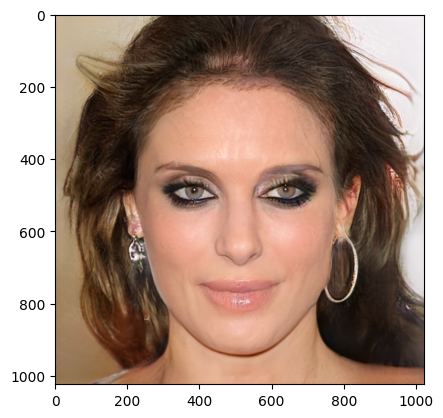

In [43]:
face = generator(test.label[0][1][26][None], 9).asnumpy()
face = np.clip(np.rint(127.5 * face + 127.5), 0.0, 255.0)
face = face.astype("uint8")
face = face.transpose(0, 2, 3, 1)
face = Image.fromarray(face[0], 'RGB')
plt.imshow(face)

In [104]:
big_chungus = stable_diffusion(face_clip_latents[2], guidance_scale = 4)

100%|██████████| 51/51 [00:06<00:00,  7.38it/s]


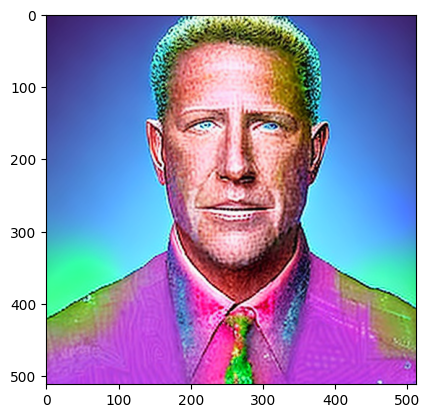

In [105]:
plt.imshow(big_chungus["sample"][0])

In [126]:
def make_examples(num_examples, face_gan_latents= face_gan_latents, face_clip_latents = face_clip_latents, face_brain_data = face_brain_data):

    for i, gan_face in enumerate(face_gan_latents):
        
    
        os.mkdir(f"/workspace/outputs/faces/test_{i}")
        
        
        face = generator(gan_face[None], 9).asnumpy()
        face = np.clip(np.rint(127.5 * face + 127.5), 0.0, 255.0)
        face = face.astype("uint8")
        face = face.transpose(0, 2, 3, 1)
        face = Image.fromarray(face[0], 'RGB')
        face.save(f"/workspace/outputs/faces/test_{i}/GAN.jpg")
        
        clip_face = face_clip_latents[i]
        for j in range(num_examples):
            std_face = stable_diffusion(clip_face, guidance_scale = 4)["sample"][0]
            std_face.save(f"/workspace/outputs/faces/test_{i}/std_{j}.jpg")
            
        print(i, end=" ")
        
    

In [127]:
make_examples(10)

100%|██████████| 51/51 [00:07<00:00,  7.27it/s]


0 

100%|██████████| 51/51 [00:07<00:00,  7.25it/s]


1 

100%|██████████| 51/51 [00:07<00:00,  7.23it/s]


2 

100%|██████████| 51/51 [00:07<00:00,  7.21it/s]


3 

100%|██████████| 51/51 [00:07<00:00,  7.23it/s]


4 

100%|██████████| 51/51 [00:07<00:00,  7.23it/s]


5 

100%|██████████| 51/51 [00:07<00:00,  7.22it/s]


6 

100%|██████████| 51/51 [00:07<00:00,  7.23it/s]


7 

100%|██████████| 51/51 [00:07<00:00,  7.21it/s]


8 

100%|██████████| 51/51 [00:07<00:00,  7.22it/s]


9 

100%|██████████| 51/51 [00:07<00:00,  7.22it/s]


10 

100%|██████████| 51/51 [00:07<00:00,  7.23it/s]


11 

100%|██████████| 51/51 [00:07<00:00,  7.23it/s]


12 

100%|██████████| 51/51 [00:07<00:00,  7.23it/s]


13 

100%|██████████| 51/51 [00:07<00:00,  7.23it/s]


14 

100%|██████████| 51/51 [00:07<00:00,  7.22it/s]


15 

100%|██████████| 51/51 [00:07<00:00,  7.21it/s]


16 

100%|██████████| 51/51 [00:07<00:00,  7.22it/s]


17 

100%|██████████| 51/51 [00:07<00:00,  7.22it/s]


18 

100%|██████████| 51/51 [00:07<00:00,  7.21it/s]


19 

100%|██████████| 51/51 [00:07<00:00,  7.22it/s]


20 

100%|██████████| 51/51 [00:07<00:00,  7.21it/s]


21 

100%|██████████| 51/51 [00:07<00:00,  7.22it/s]


22 

100%|██████████| 51/51 [00:07<00:00,  7.22it/s]


23 

100%|██████████| 51/51 [00:07<00:00,  7.21it/s]


24 

100%|██████████| 51/51 [00:07<00:00,  7.22it/s]


25 

100%|██████████| 51/51 [00:07<00:00,  7.22it/s]


26 

100%|██████████| 51/51 [00:07<00:00,  7.21it/s]


27 

100%|██████████| 51/51 [00:07<00:00,  7.21it/s]


28 

100%|██████████| 51/51 [00:07<00:00,  7.22it/s]


29 

100%|██████████| 51/51 [00:07<00:00,  7.21it/s]


30 

100%|██████████| 51/51 [00:07<00:00,  7.21it/s]


31 

100%|██████████| 51/51 [00:07<00:00,  7.22it/s]


32 

100%|██████████| 51/51 [00:07<00:00,  7.21it/s]


33 

100%|██████████| 51/51 [00:07<00:00,  7.22it/s]


34 